# Comparison and Validation of 3D Aerodynamics Methods

Here, we compare some of AeroSandbox's 3D aerodynamics analysis methods to those from other tools.

This study utilizes data courtesy of John Yost.

Consider the following swept flying-wing airplane:

In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np
from pathlib import Path

assets = Path("assets")

af = asb.Airfoil(
    name="n64_1_A612",
    coordinates=assets / "n64_1_A612.dat"
)
af.generate_polars(
    cache_filename=assets / "n64_1_A612.json"
)

airplane = asb.Airplane(
    name="NACA_RM_A50K27 Wing",
    xyz_ref=[0.58508889, 0, 0],  # CG location
    wings=[
        asb.Wing(
            name="Main Wing",
            symmetric=True,  # Should this wing be mirrored across the XZ plane?
            xsecs=[  # The wing's cross ("X") sections
                asb.WingXSec(  # Root
                    xyz_le=[0.0, 0, 0],  # Coordinates of the XSec's leading edge, relative to the wing's leading edge.
                    chord=0.4120,
                    twist=0.0,  # degrees
                    airfoil=af,  # Airfoils are blended between a given XSec and the next one.
                ),
                asb.WingXSec(
                    xyz_le=[1.1362, 1.5490, 0],
                    chord=0.2060,
                    twist=0,
                    airfoil=af,
                )
            ]
        ).subdivide_sections(10)
    ],
    c_ref=0.32
)

Visualize it:

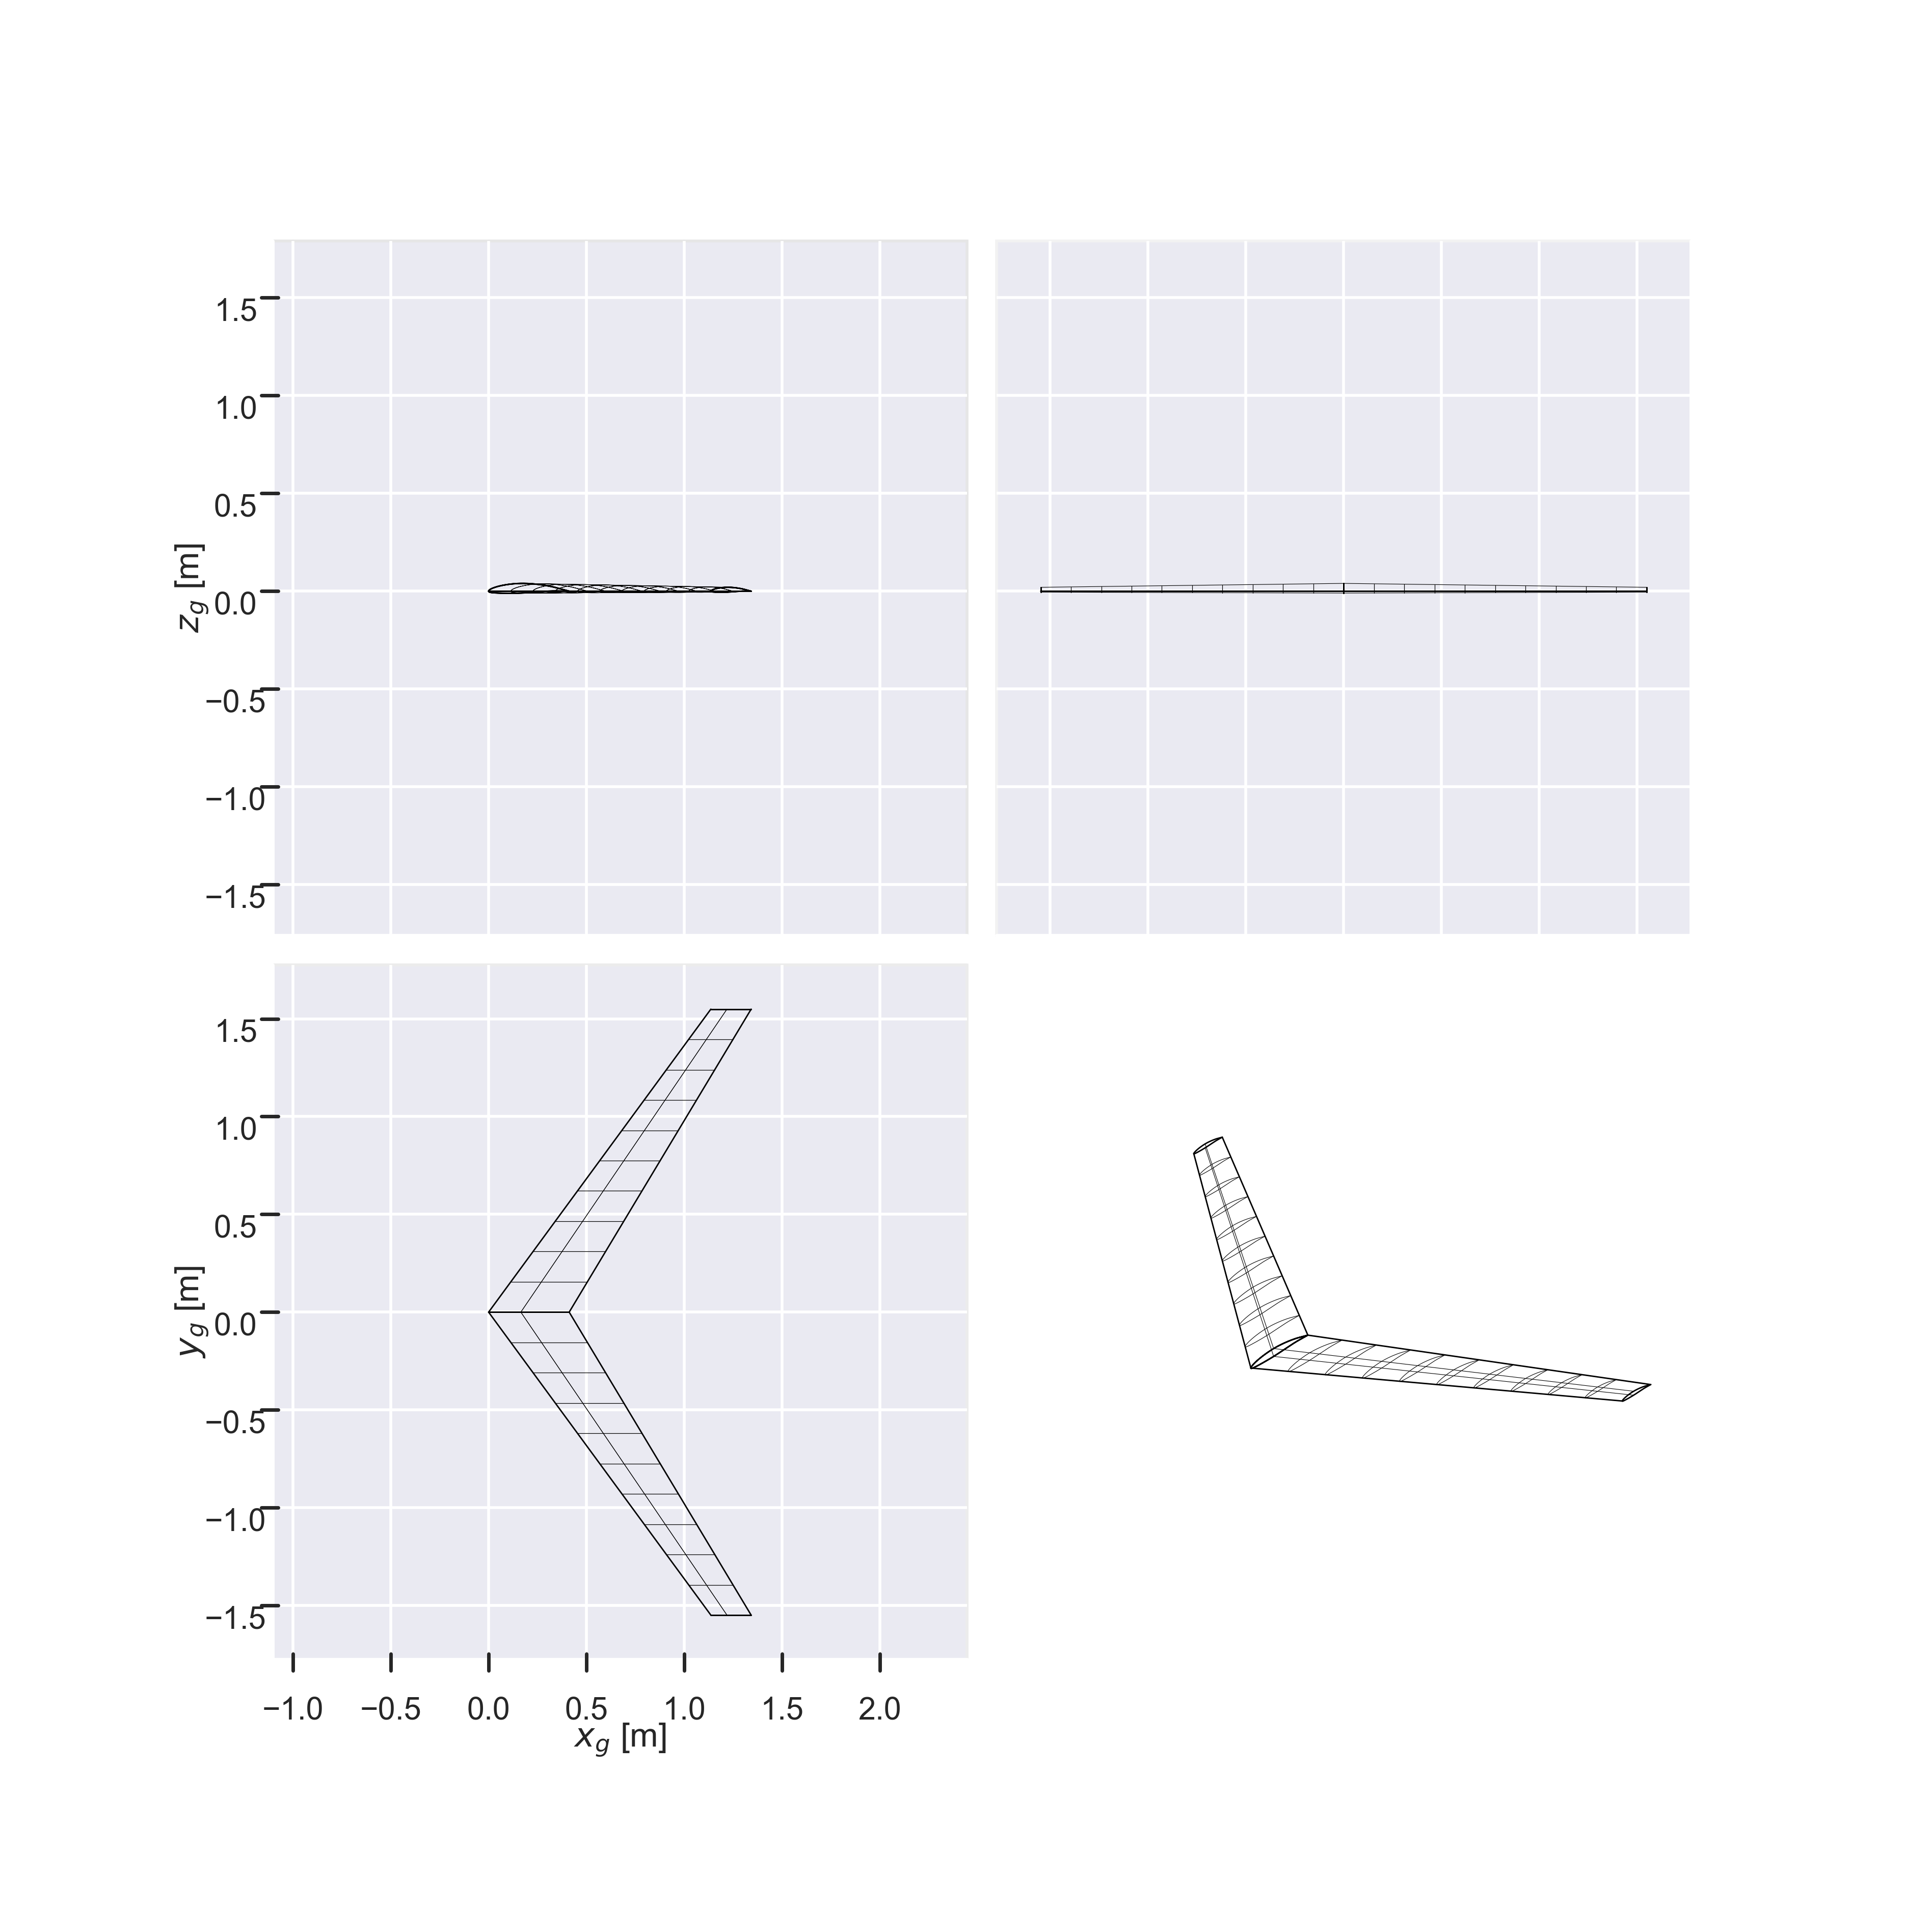

In [2]:
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

airplane.draw_three_view()

We wish to analyze it at the following aerodynamic operating point:

In [3]:
op_point = asb.OperatingPoint(
    atmosphere=asb.Atmosphere(altitude=0),
    velocity=91.3,  # m/s
    alpha=np.linspace(-10, 10, 6)
)

xyz_ref = [0.585, 0, 0]

## AeroBuildup Analysis

Analysis with AeroBuildup is simple, since it respects vectorization across operating points:

In [4]:
aerobuildup_aero = asb.AeroBuildup(
    airplane=airplane,
    op_point=op_point,
    xyz_ref=xyz_ref
).run()

aerobuildup_aero

{'F_g': [array([-155.19272951,   58.39672348,  100.07410805,  -19.65490262,
         -285.69245747, -658.23505013]),
  array([0., 0., 0., 0., 0., 0.]),
  array([-1215.18317661,   193.73192344,  1600.07135547,  2978.28684135,
          4195.16533556,  5112.65466572])],
 'F_b': [array([ 155.19272951,  -58.39672348, -100.07410805,   19.65490262,
          285.69245747,  658.23505013]),
  array([0., 0., 0., 0., 0., 0.]),
  array([ 1215.18317661,  -193.73192344, -1600.07135547, -2978.28684135,
         -4195.16533556, -5112.65466572])],
 'F_w': [array([ -58.17934092,  -37.82631987,  -44.17146061,  -84.29778242,
         -154.38678138, -239.56818507]),
  array([0., 0., 0., 0., 0., 0.]),
  array([ 1223.67074832,  -198.77475946, -1602.58917124, -2977.15849568,
         -4202.04677445, -5149.2832702 ])],
 'M_g': [array([0., 0., 0., 0., 0., 0.]),
  array([-186.54504604, -192.4067849 , -212.68868686, -219.40029696,
         -223.68619295, -200.80352277]),
  array([0., 0., 0., 0., 0., 0.])],
 'M_b

## VortexLatticeMethod Analysis

Analysis with `asb.VortexLatticeMethod` is a smidge more work, since it doesn't respect vectorization across operating points:

In [5]:
vlm_aeros = [
    asb.VortexLatticeMethod(
        airplane=airplane,
        op_point=op,
        xyz_ref=xyz_ref,
        spanwise_resolution=5
    ).run()
    for op in op_point
]

In [6]:
vlm_aero = {}

for k in vlm_aeros[0].keys():
    vlm_aero[k] = np.array([
        aero[k]
        for aero in vlm_aeros
    ])

vlm_aero

{'F_g': array([[-3.46397104e+02, -5.51199711e-14, -2.14300022e+03],
        [-6.92227109e+01, -3.83686138e-14, -6.90932990e+02],
        [ 3.22209541e+01,  8.40039843e-15,  7.89478449e+02],
        [-4.40405946e+01,  1.51252708e-14,  2.26941957e+03],
        [-2.96523013e+02, -1.23284629e-14,  3.72008501e+03],
        [-7.20312017e+02,  3.13873602e-13,  5.11323922e+03]]),
 'F_b': array([[ 3.46397104e+02, -5.51199711e-14,  2.14300022e+03],
        [ 6.92227109e+01, -3.83686138e-14,  6.90932990e+02],
        [-3.22209541e+01,  8.40039843e-15, -7.89478449e+02],
        [ 4.40405946e+01,  1.51252708e-14, -2.26941957e+03],
        [ 2.96523013e+02, -1.23284629e-14, -3.72008501e+03],
        [ 7.20312017e+02,  3.13873602e-13, -5.11323922e+03]]),
 'F_w': array([[-3.09935292e+01, -5.51199711e-14,  2.17059446e+03],
        [-3.37866205e+00, -3.83686138e-14,  6.94383730e+02],
        [-4.64892542e+00,  8.40039843e-15, -7.90122015e+02],
        [-3.51878347e+01,  1.51252708e-14, -2.26957410e+03],

## AVL (External) Analysis

In [7]:
# avl_aeros = [
#     asb.AVL(
#         airplane=airplane,
#         op_point=op,
#         xyz_ref=xyz_ref,
#         working_directory=Path.home() / "Downloads" / "test",
#         verbose=True
#     ).run()
#     for op in op_point
# ]
#
# avl_aero = {}
#
# for k in vlm_aeros[0].keys():
#     avl_aero[k] = np.array([
#         aero[k]
#         for aero in avl_aeros
#     ])
#
# avl_aero

## Comparison and Validation

In [8]:
name_data_paths = {
    # "AVL 3.35 (inviscid)"   : assets / "avl.csv",
    "AVL + XFoil"         : assets / "avl_and_xfoil.csv",
    "Panel + IBL"         : assets / "panel_and_IBL.csv",
    "OpenVSP 3.31.1 Panel": assets / "openvsp_panel.csv",
}

import pandas as pd

name_data = {
    k: pd.read_csv(
        v,

    )
    for k, v in name_data_paths.items()
}

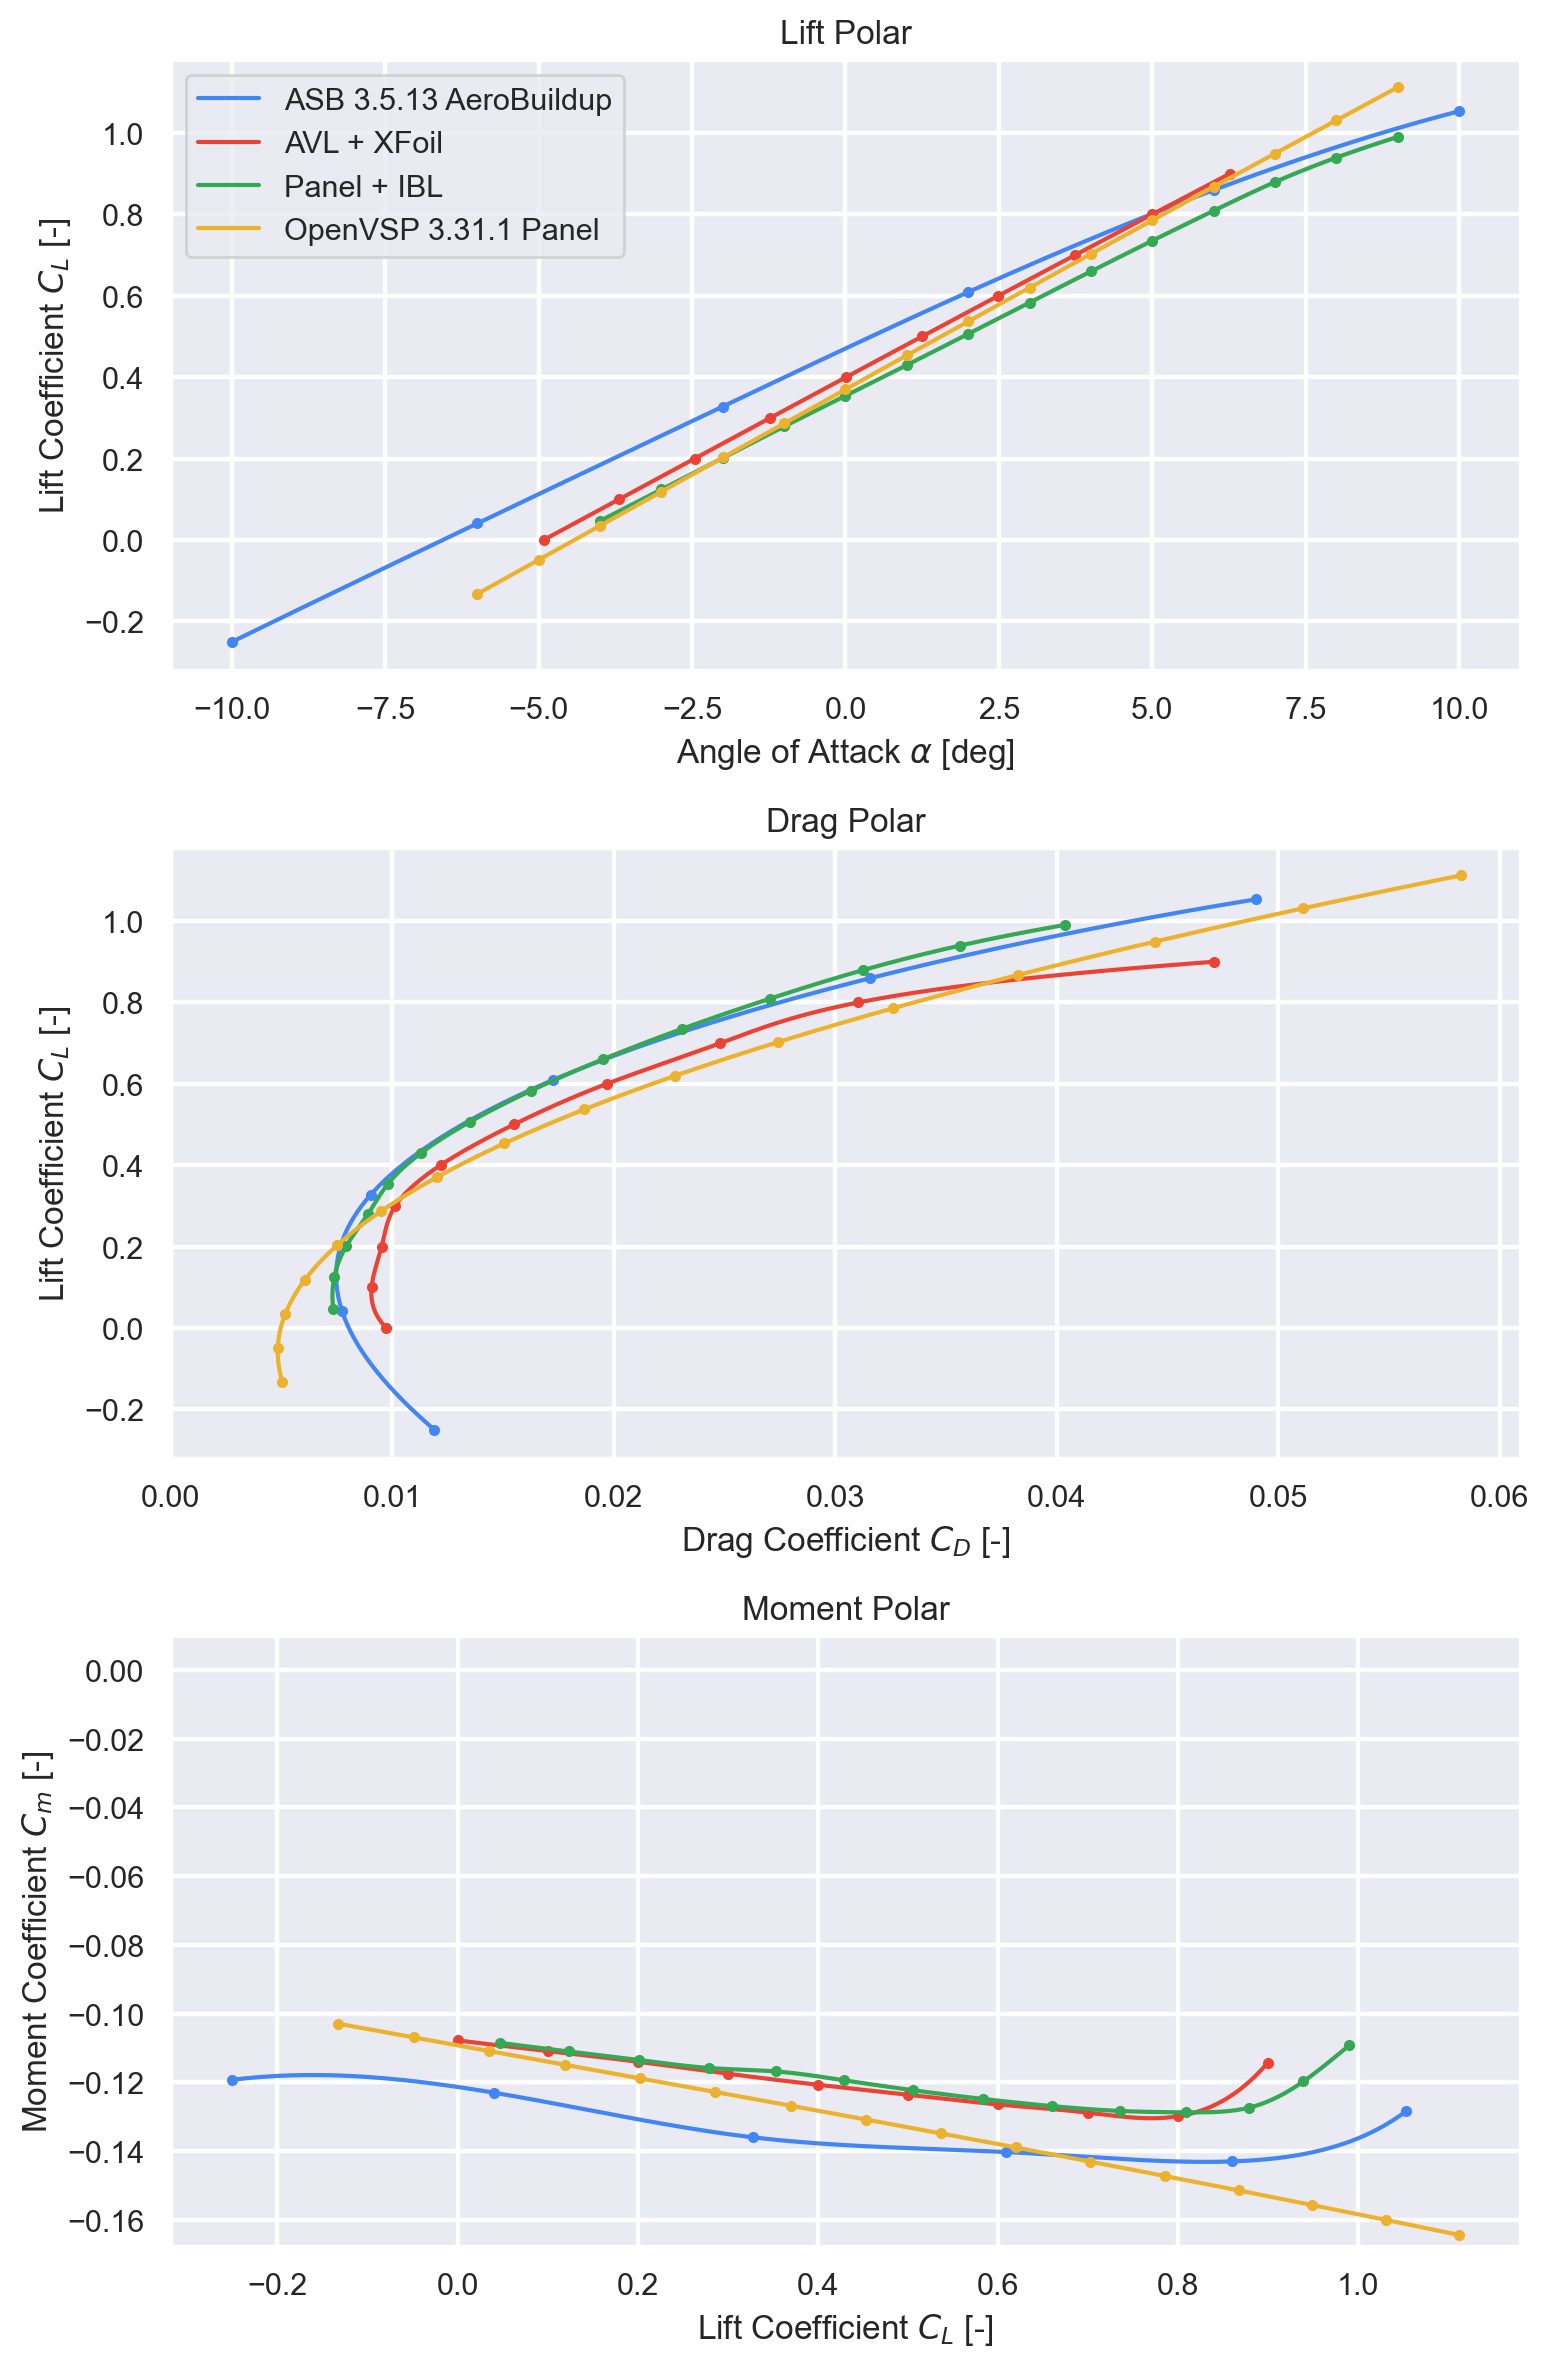

In [9]:
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

fig, ax = plt.subplots(3, 1, figsize=(8, 12), dpi=200)

for name, aero in {
    f"ASB {asb.__version__} AeroBuildup": aerobuildup_aero,
    # f"ASB {asb.__version__} VLM (inviscid)"        : vlm_aero
}.items():
    plt.sca(ax[0])

    p.plot_smooth(
        op_point.alpha,
        aero["CL"],
        ".-",
        label=name
    )

    plt.sca(ax[1])

    p.plot_smooth(
        aero["CD"],
        aero["CL"],
        ".-",
        label=name
    )

    plt.sca(ax[2])

    p.plot_smooth(
        aero["CL"],
        aero["Cm"],
        ".-",
        label=name
    )

for name, data in name_data.items():
    plt.sca(ax[0])

    p.plot_smooth(
        data["alpha"],
        data["CL"],
        ".-",
        label=name
    )

    plt.sca(ax[1])


    p.plot_smooth(
        data["CD"],
        data["CL"],
        ".-",
        label=name
    )

    plt.sca(ax[2])

    p.plot_smooth(
        data["CL"],
        data["Cm"],
        ".-",
        label=name
    )

ax[0].set_title("Lift Polar")
ax[0].set_xlabel("Angle of Attack $\\alpha$ [deg]")
ax[0].set_ylabel("Lift Coefficient $C_L$ [-]")

ax[1].set_title("Drag Polar")
ax[1].set_xlabel("Drag Coefficient $C_D$ [-]")
ax[1].set_ylabel("Lift Coefficient $C_L$ [-]")
ax[1].set_xlim(left=0)

ax[2].set_title("Moment Polar")
ax[2].set_xlabel("Lift Coefficient $C_L$ [-]")
ax[2].set_ylabel("Moment Coefficient $C_m$ [-]")
ax[2].set_ylim(top=0.01)  # Keep zero in view

plt.sca(ax[0])
p.show_plot()